In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [5]:
s2ag_papers = 'subugoe-collaborative.semantic_scholar.papers'
s2ag_venues = 'subugoe-collaborative.semantic_scholar.venues'
openalex_snapshot = 'subugoe-collaborative.openalex.works'
cr_snapshot = 'subugoe-collaborative.cr_instant.snapshot'

In [6]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [7]:
oal_c = client.query(f"""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n
                    FROM {openalex_snapshot} AS oal
                    WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                        AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                    """).to_dataframe()

In [8]:
oal_c

,n
0,39908593


In [9]:
s2_c = client.query(f"""
                    SELECT COUNT(DISTINCT(externalids.DOI)) AS n
                    FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                    WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                    """).to_dataframe()

In [10]:
s2_c

,n
0,20293269


In [11]:
cr_c = client.query(f"""
                    SELECT COUNT(DISTINCT(cr.doi)) AS n
                    FROM {cr_snapshot} AS cr
                    LEFT JOIN {openalex_snapshot} AS oal
                        ON LOWER(cr.doi) = LOWER(oal.doi)
                    LEFT JOIN {s2ag_papers} AS s2
                        ON LOWER(cr.doi) = LOWER(s2.externalids.DOI)
                    WHERE cr.type = 'journal-article' AND issued >= '2015-01-01' 
                        AND issued < '2024-01-01' AND issued IS NOT NULL AND s2.externalids.DOI IS NULL AND oal.doi IS NULL
                    """).to_dataframe()

In [12]:
cr_c

,n
0,2294


In [13]:
oal_s2_cr_c = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            JOIN {openalex_snapshot} AS oal
                                ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                            JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                AND oal.primary_location.source.type = 'journal'
                                AND oal.type IN ('article', 'review') 
                                AND ptype IN ('JournalArticle', 'Review') 
                                AND cr.type='journal-article' 
                                AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [14]:
oal_s2_cr_c

,n
0,16984736


In [15]:
oal_s2_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {openalex_snapshot} AS oal
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 
                             AND oal.primary_location.source.type = 'journal'
                             AND oal.type IN ('article', 'review')
                             AND ptype IN ('JournalArticle', 'Review')
                             AND is_paratext=False
                         """).to_dataframe()

In [16]:
oal_s2_c

,n
0,17150496


In [17]:
oal_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {openalex_snapshot} AS oal
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(oal.doi) = LOWER(cr.doi)
                         LEFT JOIN {s2ag_papers} AS s2
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 
                             AND oal.primary_location.source.type = 'journal'
                             AND oal.type IN ('article', 'review')
                             AND cr.type='journal-article' 
                             AND is_paratext=False 
                             AND is_retracted=False 
                             AND s2.externalids.DOI IS NULL
                         """).to_dataframe()

In [18]:
oal_cr_c

,n
0,2138344


In [19]:
s2_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(s2.externalids.DOI)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(s2.externalids.DOI) = LOWER(cr.doi)
                         LEFT JOIN {openalex_snapshot} AS oal
                             ON LOWER(s2.externalids.DOI) = LOWER(oal.doi)
                         WHERE s2.year BETWEEN 2015 AND 2023 
                             AND ptype IN ('JournalArticle', 'Review')
                             AND oal.doi IS NULL
                         """).to_dataframe()

In [20]:
s2_cr_c

,n
0,5222


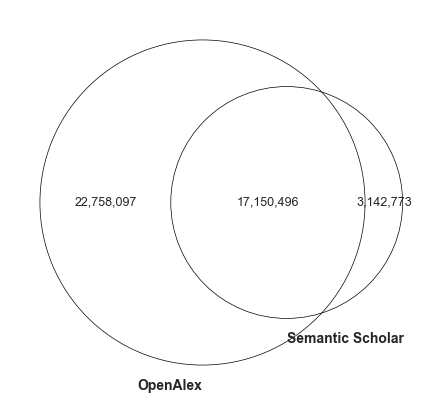

In [22]:
fig, ax = plt.subplots(figsize=(6,5))

subsets = (39908593-17150496, 20293269-17150496, 17150496)

out = venn2(subsets=subsets, 
      set_labels=('OpenAlex', 'Semantic Scholar'),
      set_colors=('white', 'white'),
      alpha=0.7)

venn2_circles(subsets=subsets, 
              linewidth=0.5)

for text in out.set_labels:
    text.set_font('Arial')
    text.set_fontsize(10)
    text.set_fontweight('bold')
for text in out.subset_labels:
    text.set_font('Arial')
    text.set_fontsize(9)
    s = int(text.get_text())
    text.set_text(f"{s:,}")
    
plt.show()
fig.savefig(f'media/venn_s2_oal.png', format='png', bbox_inches='tight', dpi=500)

In [23]:
oal_s2_ref_sum = client.query(f"""
                                SELECT 
                                    SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                    SUM(s2.referencecount) AS s2_ref_sum
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [24]:
oal_s2_ref_sum

,oal_ref_sum,s2_ref_sum
0,982585826,994263247


In [25]:
oal_s2_ref_avg = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [26]:
oal_s2_ref_avg

,oal_ref_avg,s2_ref_avg
0,25.522977,25.826302


In [27]:
oal_ref_sum = client.query(f"""
                            SELECT 
                                SUM(oal.referenced_works_count) AS oal_ref_sum, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [28]:
oal_ref_sum

,oal_ref_sum
0,979574990


In [29]:
oal_ref_avg = client.query(f"""
                            SELECT 
                                AVG(oal.referenced_works_count) AS oal_ref_avg, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [30]:
oal_ref_avg

,oal_ref_avg
0,20.506328


In [32]:
s2_ref_sum = client.query(f"""
                            SELECT 
                                SUM(s2.referencecount) AS s2_ref_sum
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                            """).to_dataframe()

In [33]:
s2_ref_sum

,s2_ref_sum
0,890745379


In [34]:
s2_ref_avg = client.query(f"""
                            SELECT 
                                AVG(s2.referencecount) AS s2_ref_avg
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                            """).to_dataframe()

In [35]:
s2_ref_avg

,s2_ref_avg
0,36.149792


In [36]:
oal_s2_ref_sum_y = client.query(f"""
                                SELECT 
                                    SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                    SUM(s2.referencecount) AS s2_ref_sum,
                                    SUM(cr.references_count) AS cr_ref_sum,
                                    oal.publication_year
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                GROUP BY publication_year
                                """).to_dataframe()

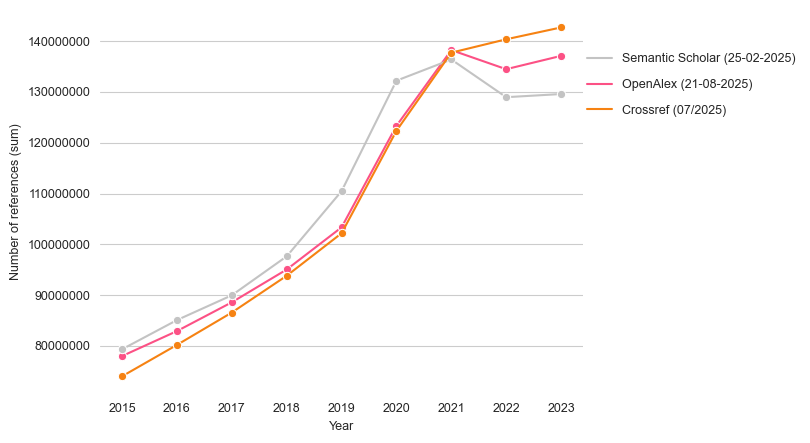

In [42]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_s2_ref_sum_y[['oal_ref_sum', 'publication_year']],
             x='publication_year',
             y='oal_ref_sum',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_sum_y[['s2_ref_sum', 'publication_year']],
             x='publication_year',
             y='s2_ref_sum',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_sum_y[['cr_ref_sum', 'publication_year']],
             x='publication_year',
             y='cr_ref_sum',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of references (sum)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (07/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_sum_ref.png', format='png', bbox_inches='tight', dpi=500)

In [43]:
oal_s2_ref_avg_y = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg,
                                    AVG(cr.references_count) AS cr_ref_avg,
                                    publication_year
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                GROUP BY publication_year
                                """).to_dataframe()

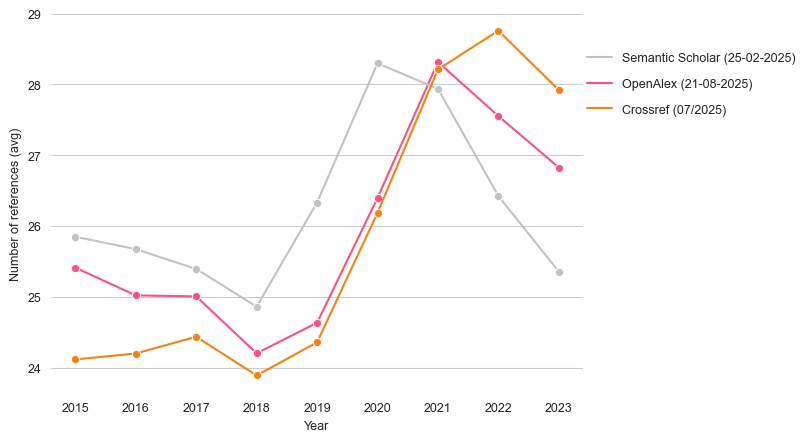

In [44]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_s2_ref_avg_y[['oal_ref_avg', 'publication_year']],
             x='publication_year',
             y='oal_ref_avg',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_avg_y[['s2_ref_avg', 'publication_year']],
             x='publication_year',
             y='s2_ref_avg',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_s2_ref_avg_y[['cr_ref_avg', 'publication_year']],
             x='publication_year',
             y='cr_ref_avg',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of references (avg)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (07/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_avg_ref.png', format='png', bbox_inches='tight', dpi=500)

In [40]:
oal_s2_ref_avg_y = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg,
                                    AVG(cr.references_count) AS cr_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [41]:
oal_s2_ref_avg_y

,oal_ref_avg,s2_ref_avg,cr_ref_avg
0,26.094427,26.323531,26.06475


In [45]:
oal_s2_ref_avg_per_journal = client.query(f"""
                                           SELECT 
                                               AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                               AVG(s2.referencecount) AS s2_ref_avg,
                                               oal.primary_location.source.display_name AS journal_title
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {s2ag_papers} AS s2
                                               ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY journal_title
                                           """).to_dataframe()

In [46]:
oal_s2_ref_avg_per_journal

,oal_ref_avg,s2_ref_avg,journal_title
0,59.437448,59.685255,Journal of Hydrology
1,7.536585,7.591463,Documentación de las Ciencias de la Información
2,1.092784,4.185567,Revista Brasileira de História do Direito
3,11.732919,14.178054,Journal of College of Medical Sciences-Nepal
4,20.646766,31.185323,International journal of engineering research ...
...,...,...,...
109150,0.000000,0.000000,SCIREA journal of energy.
109151,0.000000,0.000000,小児科
109152,0.000000,0.000000,Journal of the fantastic in the arts
109153,0.000000,0.000000,Index of Texas Archaeology: Open Access Gray L...


In [47]:
oal_s2_ref_sum_per_journal = client.query(f"""
                                           SELECT 
                                               SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                               SUM(s2.referencecount) AS s2_ref_sum,
                                               oal.primary_location.source.display_name AS journal_title
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {s2ag_papers} AS s2
                                               ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY journal_title
                                           """).to_dataframe()

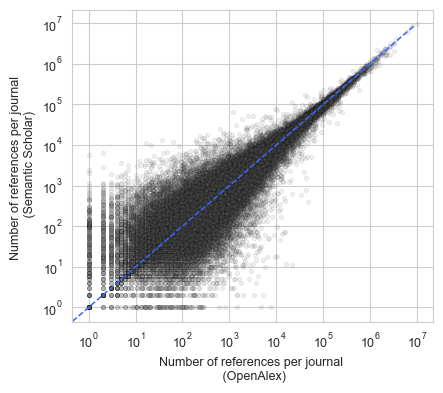

In [52]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.grid(True)

x = [x for x in range(1**1-1, 10**7, 1000000)]
y = x

sns.scatterplot(data=oal_s2_ref_sum_per_journal, 
                x='oal_ref_sum', 
                y='s2_ref_sum',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

sns.lineplot(x=x, 
             y=y, 
             color='#3366FF', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set(xlabel='Number of references per journal \n (OpenAlex)', ylabel='Number of references per journal \n (Semantic Scholar)')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig('media/oal_s2_ref_sum_per_journal.png', format='png', bbox_inches='tight', dpi=500)

In [55]:
oal_s2_ref_sum_avg_per_topic = client.query(f"""
                                             SELECT 
                                                 SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                                 AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                                 SUM(s2.referencecount) AS s2_ref_sum,
                                                 AVG(s2.referencecount) AS s2_ref_avg,
                                                 oal.primary_topic.domain.display_name AS primary_topic
                                             FROM {openalex_snapshot} AS oal
                                             JOIN {s2ag_papers} AS s2
                                                 ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                             WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                                 AND oal.primary_location.source.type = 'journal'
                                                 AND oal.type IN ('article', 'review') 
                                                 AND is_paratext=False 
                                                 AND is_retracted=False
                                             GROUP BY primary_topic
                                             """).to_dataframe()

In [59]:
oal_s2_ref_sum_avg_per_topic

,oal_ref_sum,oal_ref_avg,s2_ref_sum,s2_ref_avg,primary_topic
0,191680092,36.625827,190953855,36.487059,Life Sciences
1,235953838,23.902660,237839461,24.093678,Health Sciences
2,407198668,31.643654,400246309,31.103382,Physical Sciences
3,145744398,16.035306,163572762,17.996845,Social Sciences
4,2008830,1.398958,1650860,1.149666,None
